# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [2]:
import calendar
import gc

# Third-party library imports
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from implicit.als import AlternatingLeastSquares
from sklearn.preprocessing import LabelEncoder

# Setting constants
RANDOM_STATE = 42

# Tweaking additional settings
sns.set_theme()

/home/mle-user/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [2]:
%%time
try:
    tracks = pd.read_parquet("data/tracks.parquet")
    catalog_names = pd.read_parquet("data/catalog_names.parquet")
    events = pd.read_parquet("data/interactions.parquet")
except FileNotFoundError:
    tracks = pd.read_parquet("tracks.parquet")
    catalog_names = pd.read_parquet("catalog_names.parquet")
    events = pd.read_parquet("interactions.parquet")

CPU times: user 8.99 s, sys: 6.6 s, total: 15.6 s
Wall time: 6.44 s


# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [3]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


In [4]:
assert tracks.track_id.duplicated().sum() == 0

In [5]:
tracks.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


Будет сложно работать с такими списками в колонках. Даже пустой список будет считаться значением, поэтому следующий код, очевидно, не найдет никаких пропущенных значений:

In [6]:
tracks.isna().sum()

track_id    0
albums      0
artists     0
genres      0
dtype: int64

Применем метод explode к каждому столбцу таблицы

In [7]:
%%time
tracks = tracks \
            .explode(column=["albums"], ignore_index=True) \
            .explode(column=["artists"], ignore_index=True) \
            .explode(column=["genres"], ignore_index=True)

tracks.head()

CPU times: user 9.55 s, sys: 1.56 s, total: 11.1 s
Wall time: 10.7 s


,track_id,albums,artists,genres
0,26,3,16,11
1,26,3,16,21
2,26,2490753,16,11
3,26,2490753,16,21
4,38,3,16,11


Теперь мы можем понять, где у нас пропущены значения:

In [8]:
tracks.isna().sum()

track_id        0
albums         18
artists     41789
genres      36675
dtype: int64

In [9]:
tracks.isna().sum() / tracks.shape[0]

track_id    0.000000
albums      0.000003
artists     0.006177
genres      0.005421
dtype: float64

Видно, что датасет сожержит трек с неизвестными альбомами, исполнителями и жанрами. Рассмотрим такой трек позже.

Теперь для удобства переименуем столбцы, так как в этом случае у нас есть идентификаторы:

In [10]:
tracks = tracks.rename(
    columns= {
        "albums": "album_id",
        "artists": "artist_id",
        "genres": "genre_id",
    }
)

tracks.head(3)

,track_id,album_id,artist_id,genre_id
0,26,3,16,11
1,26,3,16,21
2,26,2490753,16,11


# Каталог

Рассмотрим фрейм catalog_names:

In [11]:
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [12]:
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [13]:
catalog_names.isna().sum()

id      0
type    0
name    0
dtype: int64

In [14]:
catalog_names.type.value_counts()

type
track     1000000
album      658724
artist     153581
genre         166
Name: count, dtype: int64

Весь фрейм состоит из данных о названиях треков, альбомах, исполнителях и жанрах. Это очень неудобный способ представления данных, поэтому лучше преобразовать фрейм в несколько таблиц:

- жанры => Информация о жанрах
- названиях треков => Информация о названиях треков
- альбомах => Информация о названиях треков
- исполнителях => Информация об исполнителях

In [15]:
genres = catalog_names \
            .query("type == 'genre'") \
            .drop("type", axis=1) \
            .rename(
                columns={
                    "id": "genre_id",
                    "name": "genre"
                }
            )

genres.head(3)

,genre_id,genre
812305,0,all
812306,1,eastern
812307,2,rusrock


In [16]:
track_names = catalog_names \
            .query("type == 'track'") \
            .drop("type", axis=1) \
            .rename(
                columns={
                    "id": "track_id",
                    "name": "track"
                }
            )

track_names.head(3)

,track_id,track
812471,26,Complimentary Me
812472,38,Momma's Boy
812473,135,Atticus


In [17]:
albums = catalog_names \
            .query("type == 'album'") \
            .drop("type", axis=1) \
            .rename(
                columns={
                    "id": "album_id",
                    "name": "album"
                }
            )

albums.head(3)

,album_id,album
0,3,Taller Children
1,12,Wild Young Hearts
2,13,Lonesome Crow


In [18]:
artists = catalog_names \
            .query("type == 'artist'") \
            .drop("type", axis=1) \
            .rename(
                columns={
                    "id": "artist_id",
                    "name": "artist"
                }
            )

artists.head(3)

,artist_id,artist
658724,4,Kenny Dorham
658725,5,Max Roach
658726,7,Francis Rossi


Объединим таблицы вместе с помощью соответствующих идентификаторов с помощью фрейма tracks, чтобы получить более наглядную информацию о треках:

In [19]:
%%time
items = tracks \
            .merge(track_names, on="track_id", how="left") \
            .merge(albums, on="album_id", how="left") \
            .merge(artists, on="artist_id", how="left") \
            .merge(genres, on="genre_id", how="left")

CPU times: user 9.73 s, sys: 3.71 s, total: 13.4 s
Wall time: 13.4 s


Оставим только информацию об идентификаторах и строковую информацию о них:

In [20]:
items = items[["track_id", "track", "artist", "album", "genre"]]
items.head()

,track_id,track,artist,album,genre
0,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop
1,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,folk
2,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop
3,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,folk
4,38,Momma's Boy,Elizabeth & the Catapult,Taller Children,pop


Чтобы иметь возможность однозначно идентифицировать трек, важно удалить неявные дубликаты и оставить только один.

In [21]:
items = items.groupby("track_id").head(1)
items.head()

,track_id,track,artist,album,genre
0,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop
4,38,Momma's Boy,Elizabeth & the Catapult,Taller Children,pop
8,135,Atticus,Noisettes,Wild Young Hearts,pop
11,136,24 Hours,Noisettes,Wild Young Hearts,pop
14,138,Don't Upset The Rhythm (Go Baby Go),Noisettes,Wild Young Hearts,pop


In [22]:
assert items.track_id.duplicated().sum() == 0

In [23]:
items.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 0 to 6765309
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   track     1000000 non-null  object
 2   artist    984631 non-null   object
 3   album     999982 non-null   object
 4   genre     996306 non-null   object
dtypes: int64(1), object(4)
memory usage: 311.1 MB


In [24]:
items.isna().sum()

track_id        0
track           0
artist      15369
album          18
genre        3694
dtype: int64

Теперь мы можем рассмотреть треки с неизвестными исполнителями, альбомами и жанрами.

In [25]:
items[(items.album.isna() == True)]

,track_id,track,artist,album,genre
2730910,20200372,На скотч,NaN,NaN,NaN
2730923,20200380,Yo Te Quiero (Я тебя люблю),NaN,NaN,NaN
2739901,20305116,Мой путь,NaN,NaN,NaN
2739914,20305121,Вечность,NaN,NaN,NaN
2837815,20756854,Виновата,NaN,NaN,NaN
2879025,21196099,Are You with Me,NaN,NaN,NaN
2879037,21196103,Historia de Amor,NaN,NaN,NaN
2879042,21196105,Stronger Than Ever,NaN,NaN,NaN
2879051,21196107,Here We Go,NaN,NaN,NaN
2879058,21196109,Long Story Short,NaN,NaN,NaN


In [26]:
unknown_artists = items[(items.artist.isna() == True)]
unknown_artists.sample(10, random_state=RANDOM_STATE)

,track_id,track,artist,album,genre
6692475,91006543,"Женский тайм-менеджмент • Анна Всехсвятская, «...",NaN,Потом доделаю,podcasts
6251773,67572186,Комиксы для убогих // Отмена школьных экзамено...,NaN,Самые честные новости,podcasts
6562778,80807054,Образование будущего: каким оно будет,NaN,Smart Reading,podcasts
6043792,61064626,Владимир Седельников. Полярные летчики. Летать...,NaN,НЕБОНутые,podcasts
5685644,51684465,Что не так с сексом на постсоветском пространс...,NaN,Это разве секс? 18+,podcasts
5611891,50125505,"150: Все, что нужно знать о Falcon Heavy",NaN,The Big Beard Theory,podcasts
6525546,78880824,Рассказы для детей в исполнении автора. (читае...,NaN,Много букв,podcasts
6307438,69466617,Бритни Спирс в плену у собственного отца,NaN,Сплетни,podcasts
5785155,53689134,"«Хочу, но не могу»: как использовать психологи...",NaN,Игры разума,podcasts
6063192,61645665,0942 Daily Easy English Lesson PODCAST—to plug...,NaN,Daily Easy English Expression Podcast,podcasts


In [27]:
unknown_artists.genre.value_counts()

genre
podcasts            14954
fairytales            273
fiction                40
poemsforchildren       29
selfdevelopment        13
electronics            13
rock                    3
country                 2
community               2
classical               1
pop                     1
forchildren             1
local-indie             1
asmr                    1
work                    1
hls                     1
Name: count, dtype: int64

In [28]:
items[(items.genre.isna() == True)].sample(10, random_state=RANDOM_STATE)

,track_id,track,artist,album,genre
1172203,1956422,All I Want for Christmas Is You,My Chemical Romance,Gift Wrapped: Regifted,NaN
6662702,88690682,Птеранодон,Pinkfong,Песни Про Динозавров,NaN
1409172,3861566,She's So Gone,Naomi Scott,Disney Singalong - Lemonade Mouth,NaN
2669653,19677621,Cannon in D,Classical Lullabies,Classical Lullabies,NaN
1884705,8656811,It's The Most Wonderful Time Of The Year,Rick Braun,Swingin' In The Snow,NaN
5462314,44904224,The Fall,My Little Pony,My Little Pony: The Movie,NaN
1430139,4079626,Bloody Mary,Twinkle Twinkle Little Rock Star,Lullaby Versions of Lady GaGa V.2,NaN
4256412,25164057,ACADECA,Twilight Sparkle,Friendship Games,NaN
3083083,21955336,Dance with the Devil,Twinkle Twinkle Little Rock Star,Lullaby Versions of Breaking Benjamin,NaN
4754746,33189013,That House,Dance With the Dead,B-Sides: Vol. 1,NaN


Представим наглядно информацию о жанрах:

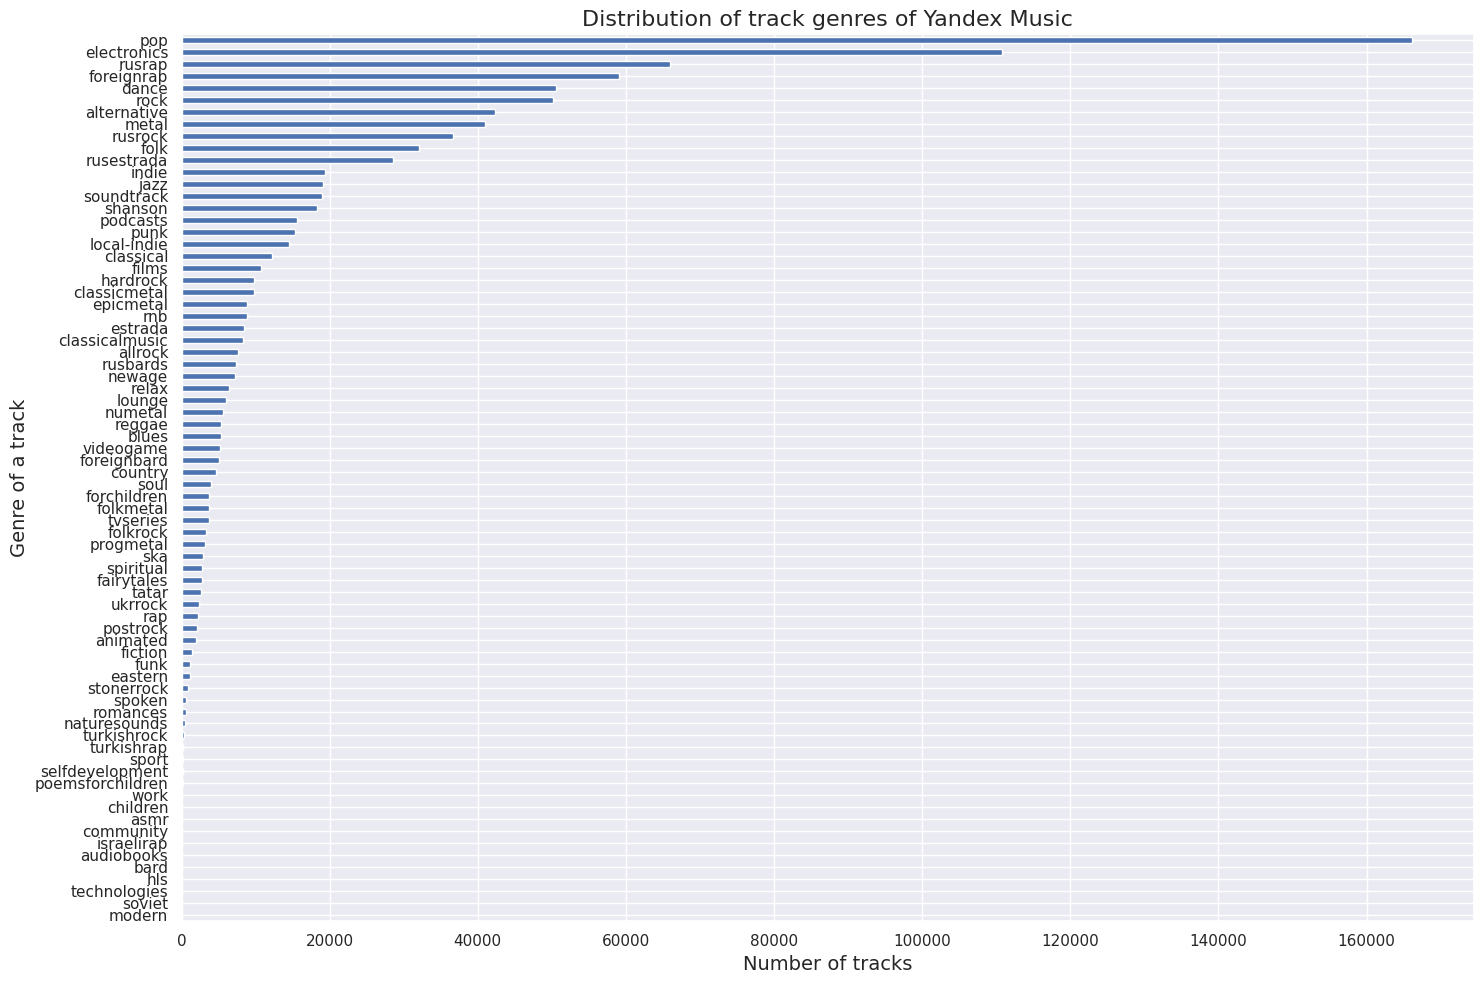

In [29]:
plt.figure(figsize=(15, 10))
items.genre.value_counts().sort_values().plot(kind="barh")
plt.ylabel("Genre of a track", fontsize=14)
plt.xlabel("Number of tracks", fontsize=14)
plt.title("Distribution of track genres of Yandex Music", fontsize=16)
plt.tight_layout()

Видно, что наибольшая доля треков в данных относится к музыкальным композициям жанров pop, electronic и rusrap. 

Рассмотрим общую информацию о треке, в то же время сосредоточив внимание на использовании памяти фрейма данных:

In [30]:
items.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 0 to 6765309
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   track     1000000 non-null  object
 2   artist    984631 non-null   object
 3   album     999982 non-null   object
 4   genre     996306 non-null   object
dtypes: int64(1), object(4)
memory usage: 311.1 MB


In [31]:
items.track_id.min(), items.track_id.max()

(26, 101521819)

Мы можем немного уменьшить размер этого фрейма данных, используя преобразование типов данных. Известно, что максимальное значение, которое может принимать тип int32, составляет около 2 миллиардов, что выше максимального значения track identifier, поэтому изменим тип track_id с int64 на int32:

In [32]:
items["track_id"] = items["track_id"].astype("int32")

In [33]:
items.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 0 to 6765309
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int32 
 1   track     1000000 non-null  object
 2   artist    984631 non-null   object
 3   album     999982 non-null   object
 4   genre     996306 non-null   object
dtypes: int32(1), object(4)
memory usage: 307.3 MB


In [34]:
items.head()

,track_id,track,artist,album,genre
0,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop
4,38,Momma's Boy,Elizabeth & the Catapult,Taller Children,pop
8,135,Atticus,Noisettes,Wild Young Hearts,pop
11,136,24 Hours,Noisettes,Wild Young Hearts,pop
14,138,Don't Upset The Rhythm (Go Baby Go),Noisettes,Wild Young Hearts,pop


# События

Теперь перейдем к анализу данных о взаимодействии пользователей с музыкальными треками:

In [35]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


In [36]:
events.head()

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [37]:
print("Number of unique users: {:,}".format(events.user_id.nunique()))
print("Number of unique tracks: {:,}".format(events.track_id.nunique()))

Number of unique users: 1,373,221
Number of unique tracks: 1,000,000


In [38]:
events = events.drop("track_seq", axis=1)
events.head()

,user_id,track_id,started_at
0,0,99262,2022-07-17
1,0,589498,2022-07-19
2,0,590262,2022-07-21
3,0,590303,2022-07-22
4,0,590692,2022-07-22


In [39]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 3 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int32(2)
memory usage: 5.0 GB


# Выводы

- Загрузили данные о музыкальных треках и взаимодействии с ними.

- Установлено и исправлено  несоответствие формата данных музыкальных треков

- Прообразованы данные каталога в несколько подфреймов 

# === ЭТАП 2 ===

# EDA

Набор данных о взаимодействиях пользователей содержит более 220 млн записей, что создаёт риск переполнения памяти. Даже простые операции или объединение с другими таблицами могут вызвать сбой ядра из-за нехватки ОЗУ.

Для решения этой проблемы в рамках EDA мы используем случайную 25% выборку из всех событий. Чтобы обеспечить воспроизводимость результатов, генератор случайных чисел инициализирован константой RANDOM_STATE

In [40]:
%%time
events_sample = events.sample(frac=0.25, random_state=RANDOM_STATE)
events_sample.head()

CPU times: user 11 s, sys: 630 ms, total: 11.6 s
Wall time: 11.6 s


,user_id,track_id,started_at
130,844258,3581309,2022-06-05
433,1091434,14937363,2022-06-29
526,73981,48591660,2022-09-26
9,78605,732405,2022-09-14
1202,1273064,40339506,2022-08-24


In [41]:
print("Number of unique users: {:,}".format(events_sample.user_id.nunique()))
print("Number of unique tracks: {:,}".format(events_sample.track_id.nunique()))
print("Number of events: {:,}".format(events_sample.shape[0]))

Number of unique users: 1,365,137
Number of unique tracks: 950,986
Number of events: 55,657,474


При 25% выборке объём данных сократился со 220 до 55 млн записей, при этом сохранена большая часть уникальных пользователей и практически все треки.

Для дальнейшего анализа добавим к выборке данные о названиях треков и их жанрах.

In [42]:
events_sample = events_sample.merge(
    items[["track_id", "track", "genre"]],
    on="track_id",
    how="left",
)
events_sample.head()

,user_id,track_id,started_at,track,genre
0,844258,3581309,2022-06-05,Somebody That I Used To Know,pop
1,1091434,14937363,2022-06-29,The Monster,foreignrap
2,73981,48591660,2022-09-26,Шар,pop
3,78605,732405,2022-09-14,ХОЧЕШЬ?,rusrock
4,1273064,40339506,2022-08-24,Компромисс,rusrock


# Анализ прослушиваний по месяцам

Для наглядного представления динамики прослушиваний сгруппируем данные по месяцам. Это позволит избежать перегрузки графика из-за большого количества отдельных треков.

Сначала создадим вспомогательную структуру для сопоставления номеров месяцев с их названиями — она понадобится для визуализации.

In [43]:
id2month_mapping = {i: name for i, name in zip(range(12), calendar.month_name[1:])}
id2month_mapping

{0: 'January',
 1: 'February',
 2: 'March',
 3: 'April',
 4: 'May',
 5: 'June',
 6: 'July',
 7: 'August',
 8: 'September',
 9: 'October',
 10: 'November',
 11: 'December'}

Поскольку started_at имеет формат даты и времени, номер месяца можно извлечь напрямую.

In [44]:
events_sample["month"] = events_sample["started_at"].dt.month
events_sample.head()

,user_id,track_id,started_at,track,genre,month
0,844258,3581309,2022-06-05,Somebody That I Used To Know,pop,6
1,1091434,14937363,2022-06-29,The Monster,foreignrap,6
2,73981,48591660,2022-09-26,Шар,pop,9
3,78605,732405,2022-09-14,ХОЧЕШЬ?,rusrock,9
4,1273064,40339506,2022-08-24,Компромисс,rusrock,8


Теперь сгруппируем данные по месяцам прослушивания и используем подготовленное сопоставление, чтобы сделать ось X читаемой.

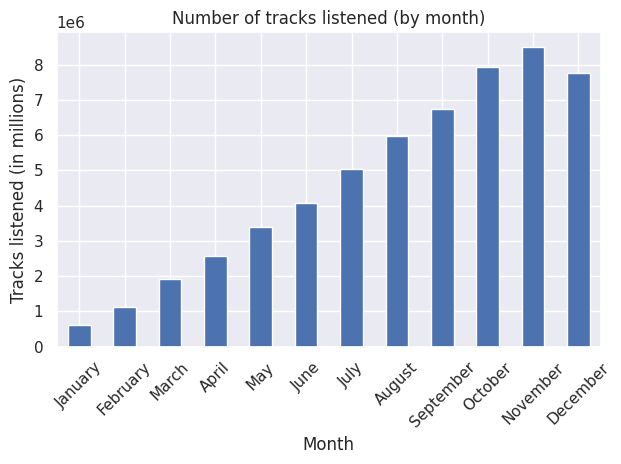

In [45]:
events_sample \
            .groupby("month")["track"] \
            .count() \
            .sort_index() \
            .plot(kind="bar")

plt.xlabel("Month")
plt.ylabel("Tracks listened (in millions)")
plt.title("Number of tracks listened (by month)")
plt.xticks(list(id2month_mapping.keys()), list(id2month_mapping.values()), rotation=45)
plt.tight_layout()
plt.show()

# Самые популярные треки

Подсчитаем топ-30 самых популярных треков:

In [46]:
events_sample.track_id \
            .value_counts() \
            .head(30) \
            .reset_index() \
            .merge(
                items[["track_id", "track", "artist"]],
                on="track_id",
                how="left",
            )[["track_id", "track", "artist", "count"]].set_index("track_id")

,track,artist,count
track_id,,,
53404,Smells Like Teen Spirit,Nirvana,27596
33311009,Believer,Imagine Dragons,26830
178529,Numb,Linkin Park,25543
35505245,I Got Love,Miyagi & Эндшпиль,24684
65851540,Юность,Dabro,21665
24692821,Way Down We Go,KALEO,21587
32947997,Shape of You,Ed Sheeran,21530
795836,Shape Of My Heart,Sting,21487
51241318,In The End,Tommee Profitt,21457


# Самые популярные жанры

Топ-30 самых популярных жанров:

In [47]:
events_sample.genre.value_counts().head(30)

genre
pop               13873850
rusrap             6327969
electronics        4672913
dance              3849000
rusrock            3290821
foreignrap         2951954
rock               2588872
alternative        2486226
metal              1600655
indie              1364048
rusestrada         1221573
local-indie        1017882
punk                885731
folk                851817
numetal             559733
shanson             553822
soundtrack          547633
films               524561
hardrock            514213
rnb                 481071
classicmetal        476886
jazz                416389
estrada             356269
epicmetal           316098
classicalmusic      314966
classical           295505
allrock             294781
foreignbard         274326
ukrrock             194016
folkrock            189807
Name: count, dtype: int64

# Треки без прослушиваний

Чтобы выявить треки, которые никто не слушал, сравним идентификаторы в нашей выборке (events_sample) с общим списком треков (items) и найдём разницу.

In [48]:
items_track_ids = set(items.track_id.values.tolist())
events_track_ids = set(events_sample.track_id.values.tolist())

no_listens_ids = list(items_track_ids - events_track_ids)

print("Number of tracks not listened to: {:,}".format(len(no_listens_ids)))
print("Share: {:.2%}".format(len(no_listens_ids) / items.shape[0]))

Number of tracks not listened to: 49,014
Share: 4.90%


In [49]:
assert len(events_track_ids) + len(no_listens_ids) == items.shape[0]

In [50]:
items[items.track_id.isin(no_listens_ids)].sample(10, random_state=RANDOM_STATE)

,track_id,track,artist,album,genre
5120396,38363244,Trap Life,Trap,Trap,foreignrap
5595246,49364277,Motivasyon,Ben Fero,ORMAN KANUNLARI,turkishrap
4313055,25427236,Волшебница,Центр,Легенды Москвы,rusrock
6053380,61394657,Set Me Free,Desib-L,Set Me Free,electronics
4350583,25764755,Money and Run,UNKLE,Global Underground #41: James Lavelle Presents...,electronics
4360437,25891460,Remembering,Omega,The Beaty Sixties,rock
5478335,45397998,Elephant March,Wooli,Elephant March,electronics
4938314,35757780,"Страсти по Матфею, Тайная вечеря: Един от вас ...","Московский Синодальный хор, Владимир Федосеев,...",Митрополит Иларион: Музыка для оркестра и хора,classical
4476292,28345010,This Boy,The Beatles,Anthology 1,rock
5654642,51186002,"Русско- турецкие войны в программе ""Виват Исто...",NaN,"Виват, история!",podcasts


Сравнение с выборкой показало, что около 50 тысяч треков не имеют прослушиваний. Однако, поскольку мы анализируем не полные данные, а лишь выборку, этот результат может быть неполным. Как было видно ранее, в исходных данных каждый из 1 миллиона уникальных треков был прослушан хотя бы один раз.

# Преобразование данных

Приведём данные к формату, подходящему для построения системы рекомендаций.

Начнём со сброса индекса таблицы items:

In [51]:
items.head()

,track_id,track,artist,album,genre
0,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop
4,38,Momma's Boy,Elizabeth & the Catapult,Taller Children,pop
8,135,Atticus,Noisettes,Wild Young Hearts,pop
11,136,24 Hours,Noisettes,Wild Young Hearts,pop
14,138,Don't Upset The Rhythm (Go Baby Go),Noisettes,Wild Young Hearts,pop


In [52]:
items = items.reset_index(drop=True)
items.head()

,track_id,track,artist,album,genre
0,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop
1,38,Momma's Boy,Elizabeth & the Catapult,Taller Children,pop
2,135,Atticus,Noisettes,Wild Young Hearts,pop
3,136,24 Hours,Noisettes,Wild Young Hearts,pop
4,138,Don't Upset The Rhythm (Go Baby Go),Noisettes,Wild Young Hearts,pop


In [53]:
item_encoder = LabelEncoder()
item_encoder.fit(items["track_id"])
items["track_id_encoded"] = item_encoder.transform(items["track_id"])
items.head()

,track_id,track,artist,album,genre,track_id_encoded
0,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop,0
1,38,Momma's Boy,Elizabeth & the Catapult,Taller Children,pop,1
2,135,Atticus,Noisettes,Wild Young Hearts,pop,2
3,136,24 Hours,Noisettes,Wild Young Hearts,pop,3
4,138,Don't Upset The Rhythm (Go Baby Go),Noisettes,Wild Young Hearts,pop,4


Cохраним кодировщик идентификаторов товаров в отдельном файле, чтобы не пришлось снова обучать кодировщик:

In [54]:
try:
    with open("encoders/item_encoder.pkl", "wb") as fd:
        joblib.dump(item_encoder, fd)
except FileNotFoundError:
    with open("item_encoder.pkl", "wb") as fd:
        joblib.dump(item_encoder, fd)

Мы также можем немного уменьшить объем памяти, занимаемый фреймворком данных, выполнив преобразование типов данных:

In [55]:
items.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   track_id          1000000 non-null  int32 
 1   track             1000000 non-null  object
 2   artist            984631 non-null   object
 3   album             999982 non-null   object
 4   genre             996306 non-null   object
 5   track_id_encoded  1000000 non-null  int64 
dtypes: int32(1), int64(1), object(4)
memory usage: 307.3 MB


In [56]:
items["track_id_encoded"] = items["track_id_encoded"].astype("int32")

In [57]:
items.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   track_id          1000000 non-null  int32 
 1   track             1000000 non-null  object
 2   artist            984631 non-null   object
 3   album             999982 non-null   object
 4   genre             996306 non-null   object
 5   track_id_encoded  1000000 non-null  int32 
dtypes: int32(2), object(4)
memory usage: 303.5 MB


# Работа с событиями

Как уже отмечалось, полный набор данных слишком велик для обработки. Ранее мы использовали случайную 25% выборку записей, но этот подход может терять часть истории взаимодействий отдельных пользователей, что важно для рекомендаций.

Поэтому теперь мы выберем 25% случайных **пользователей**, но возьмём **все их события**. Это позволит сохранить полную историю взаимодействий выбранной группы пользователей.

In [58]:
events_user_ids = events.user_id.unique()
events_user_ids

array([      0,       1,       2, ..., 1374580, 1374581, 1374582],
      dtype=int32)

In [59]:
users_share = 0.25
num_users = int(users_share * len(events_user_ids))
print("Number of new unique users: {:,}".format(num_users))

Number of new unique users: 343,305


In [60]:
np.random.seed(RANDOM_STATE)
events_user_ids_new = np.random.choice(events_user_ids, size=num_users)
events_user_ids_new

array([ 122068,  671804,  132054, ..., 1264082, 1169057,  732620],
      dtype=int32)

In [61]:
events = events[events.user_id.isin(events_user_ids_new)]
print("Number of events: {:,}".format(events.shape[0]))

Number of events: 49,395,087


In [62]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49395087 entries, 0 to 23
Data columns (total 3 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int32(2)
memory usage: 1.1 GB


In [63]:
events.isna().sum()

user_id       0
track_id      0
started_at    0
dtype: int64

In [64]:
events.head()

,user_id,track_id,started_at
0,4,966,2022-03-29
1,4,4094,2022-03-29
2,4,9760,2022-03-29
3,4,9769,2022-03-31
4,4,18392,2022-04-01


Для удобства закодируем также идентификаторы пользователей. Чтобы сохранить соответствие, будем использовать уже обученный кодировщик для идентификаторов треков.

In [65]:
%%time
user_encoder = LabelEncoder()
user_encoder.fit(events["user_id"])
events["user_id_encoded"] = user_encoder.transform(events["user_id"])
events["track_id_encoded"] = item_encoder.transform(events["track_id"])
events.head()

CPU times: user 11.1 s, sys: 411 ms, total: 11.5 s
Wall time: 11.5 s


,user_id,track_id,started_at,user_id_encoded,track_id_encoded
0,4,966,2022-03-29,0,93
1,4,4094,2022-03-29,0,881
2,4,9760,2022-03-29,0,1962
3,4,9769,2022-03-31,0,1966
4,4,18392,2022-04-01,0,3361


In [66]:
try:
    with open("encoders/user_encoder.pkl", "wb") as fd:
        joblib.dump(user_encoder, fd)
except FileNotFoundError:
    with open("user_encoder.pkl", "wb") as fd:
        joblib.dump(user_encoder, fd)

# Сохранение данных

Сохраним данные в двух файлах  recsys/data/:

items.parquet — все данные о музыкальных треках,
events.parquet — все данные о взаимодействиях.

In [67]:
try:
    items.to_parquet("data/items.parquet")
    events.to_parquet("data/events.parquet")
except OSError:
    items.to_parquet("items.parquet")
    events.to_parquet("events.parquet")

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [68]:
# Удаляем основные датафреймы
del tracks
del catalog_names
del events_sample
del events 

# Удаляем вспомогательные датафреймы
del genres
del track_names
del albums
del artists

# Удаляем объекты энкодеров (они уже сохранены в файлы)
del item_encoder
del user_encoder

# Удаляем временные структуры данных
del items_track_ids
del events_track_ids
del no_listens_ids
del events_user_ids
del events_user_ids_new

# Удаляем mapping
del id2month_mapping

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [69]:
try:
    items = pd.read_parquet("data/items.parquet")
except FileNotFoundError:
    items = pd.read_parquet("items.parquet")
items.sample(5, random_state=RANDOM_STATE)

,track_id,track,artist,album,genre,track_id_encoded
987231,95229664,Have Yourself A Merry Little Christmas,Billy Porter,Have Yourself A Merry Little Christmas,pop,987231
79954,700056,"Баллада о том, кто недожил (Прерванный полёт)",Владимир Высоцкий,Баллады к кинофильму «Бегство мистера Мак-Кинли»,rusbards,79954
567130,39019190,Осторожно,Группа «ГРЕЙС»,Верю и люблю,shanson,567130
500891,34625231,In The Air,Raven & Kreyn,In The Air,electronics,500891
55399,518436,Take It In,Hot Chip,One Life Stand,electronics,55399


In [70]:
try:
    events = pd.read_parquet("data/events.parquet")
except FileNotFoundError:
    events = pd.read_parquet("events.parquet")
events.sample(5, random_state=RANDOM_STATE)

,user_id,track_id,started_at,user_id_encoded,track_id_encoded
381,25406,20712541,2022-07-25,5626,319486
275,1251371,26405349,2022-08-31,276753,390789
21,790745,33290410,2022-12-05,174607,483320
560,388831,17562805,2022-07-18,85925,277908
7,867911,366707,2022-08-23,191746,43612


In [71]:
try:
    with open("encoders/user_encoder.pkl", "rb") as fd:
        user_encoder = joblib.load(fd)
except FileNotFoundError:
    with open("user_encoder.pkl", "rb") as fd:
        user_encoder = joblib.load(fd)

In [72]:
try:
    with open("encoders/item_encoder.pkl", "rb") as fd:
        item_encoder = joblib.load(fd)
except FileNotFoundError:
    with open("item_encoder.pkl", "rb") as fd:
        item_encoder = joblib.load(fd)

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

Для построения рекомендательной системы сначала создадим аналог рейтинга. В качестве него используем нормализованное количество прослушиваний треков: 1.0 присвоим самому популярному треку. После этого данные можно будет разделить на обучающие и тестовые.

In [73]:
track_popularity = events.groupby("track_id_encoded")["user_id_encoded"].count()
track_popularity /= track_popularity.max()
track_popularity = track_popularity.reset_index()
track_popularity = track_popularity.rename(
    columns={
        "user_id_encoded": "tracks_played"
    }
)
track_popularity

,track_id_encoded,tracks_played
0,1,0.000082
1,2,0.000367
2,3,0.000163
3,4,0.000245
4,5,0.000163
...,...,...
936071,999995,0.000082
936072,999996,0.000653
936073,999997,0.000122
936074,999998,0.000082


In [74]:
events = events.merge(
    track_popularity,
    on="track_id_encoded",
    how="left"
)
events.head()

,user_id,track_id,started_at,user_id_encoded,track_id_encoded,tracks_played
0,4,966,2022-03-29,0,93,0.019545
1,4,4094,2022-03-29,0,881,0.117227
2,4,9760,2022-03-29,0,1962,0.013628
3,4,9769,2022-03-31,0,1966,0.343561
4,4,18392,2022-04-01,0,3361,0.064918


Теперь мы можем разделить данные (где мы будем использовать 16-12-2022 в качестве критерия разделения).:

In [75]:
train_test_global_time_split_date = pd.to_datetime("2022-12-16")

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx].copy()
events_test = events[~train_test_global_time_split_idx].copy()

print("Train set events number: {:,}".format(events_train.shape[0]))
print("Test set events number: {:,}".format(events_test.shape[0]))

Train set events number: 46,309,577
Test set events number: 3,085,510


При разделении данных важно контролировать количество уникальных, обычных и «холодных» пользователей в обеих выборках

In [76]:
users_train = events_train["user_id_encoded"].drop_duplicates().tolist()
users_test = events_test["user_id_encoded"].drop_duplicates().tolist()

common_users = set(users_train) & set(users_test)
cold_users = (set(users_train) | set(users_test)) - set(users_train)

print("Number of unique train users: {:,}".format(len(users_train)))
print("Number of unique test users: {:,}".format(len(users_test)))
print("Number of common users: {:,}".format(len(common_users)))
print("Number of cold users: {:,}".format(len(cold_users)))

Number of unique train users: 297,170
Number of unique test users: 173,677
Number of common users: 166,913
Number of cold users: 6,764


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [77]:
top_popular = events_train.track_id \
            .value_counts() \
            .head(100) \
            .reset_index() \
            .rename(
                columns={
                    "count": "tracks_played",
                }
            ) \
            .merge(
                items[["track_id", "track", "artist"]],
                on="track_id",
                how="left",
            )[["track_id", "track", "artist", "tracks_played"]]
top_popular["track_id_encoded"] = item_encoder.transform(top_popular["track_id"])
top_popular

,track_id,track,artist,tracks_played,track_id_encoded
0,53404,Smells Like Teen Spirit,Nirvana,24274,9098
1,33311009,Believer,Imagine Dragons,22382,483876
2,178529,Numb,Linkin Park,22198,26665
3,35505245,I Got Love,Miyagi & Эндшпиль,21120,512157
4,24692821,Way Down We Go,KALEO,18719,368072
...,...,...,...,...,...
95,75944934,Astronaut In The Ocean,Masked Wolf,10550,904055
96,75642961,Венера-Юпитер,Ваня Дмитриенко,10541,902660
97,68348389,Minor,Miyagi & Andy Panda,10516,848373
98,68562711,Сияй,Ramil',10474,849895


In [78]:
try:
    top_popular.to_parquet("data/top_popular.parquet")
except OSError:
    top_popular.to_parquet("top_popular.parquet")

# Персональные

Рассчитаем персональные рекомендации.

In [79]:
user_item_matrix_train = scipy.sparse.csr_matrix(
    (
    events_train["tracks_played"],
    (events_train["user_id_encoded"], events_train["track_id_encoded"])
    ),
    dtype=np.int8
)
user_item_matrix_train

<Compressed Sparse Row sparse matrix of dtype 'int8'
	with 46309577 stored elements and shape (303934, 1000000)>

Матрица имеет размер 303934 × 1000000 (пользователи × треки). После её подготовки можно запускать алгоритм ALS

In [80]:
als_params = {
    "factors": 50,
    "iterations": 100,
    "regularization": 0.05,
    "random_state": RANDOM_STATE,
}

als_model = AlternatingLeastSquares(**als_params)
als_model.fit(user_item_matrix_train)

/home/mle-user/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [11:11<00:00,  6.72s/it]


Обученную модель используем для генерации рекомендаций. Каждому пользователю подберём 10 треков

In [81]:
%%time
user_ids_encoded = range(len(user_encoder.classes_))

als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, 
    N=10,
)

CPU times: user 28min 59s, sys: 11min 27s, total: 40min 27s
Wall time: 11min 7s


Теперь приведём результаты рекомендаций к удобному для восприятия виду

In [82]:
track_ids_encoded = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_encoded": user_ids_encoded,
    "track_id_encoded": track_ids_encoded.tolist(), 
    "score": als_scores.tolist(),
})
als_recommendations = als_recommendations.explode(["track_id_encoded", "score"], ignore_index=True)

als_recommendations["track_id_encoded"] = als_recommendations["track_id_encoded"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_encoded"])
als_recommendations["track_id"] = item_encoder.inverse_transform(als_recommendations["track_id_encoded"])
als_recommendations = als_recommendations.drop(columns=["user_id_encoded", "track_id_encoded"])

als_recommendations = als_recommendations[["user_id", "track_id", "score"]]

In [83]:
als_recommendations

,user_id,track_id,score
0,4,53404,1.788324e-13
1,4,50834580,4.845297e-20
2,4,81848875,4.298855e-20
3,4,32182642,4.107725e-20
4,4,49961817,3.987751e-20
...,...,...,...
3039335,1374579,88476064,7.005857e-20
3039336,1374579,43716993,6.977971e-20
3039337,1374579,628320,6.969311e-20
3039338,1374579,29611476,6.623787e-20


В результате для каждого пользователя сформировано 10 рекомендаций

In [84]:
als_recommendations.query("user_id == 4").merge(items, on="track_id", how="left")

,user_id,track_id,score,track,artist,album,genre,track_id_encoded
0,4,53404,1.788324e-13,Smells Like Teen Spirit,Nirvana,Nevermind,alternative,9098
1,4,50834580,4.845297e-20,Девочка-война,HammAli & Navai,Девочка-война,rusrap,692312
2,4,81848875,4.298855e-20,Федерико Феллини,Galibri & Mavik,Федерико Феллини,pop,935913
3,4,32182642,4.107725e-20,Лирика,Filatov & Karas,Лирика,dance,461481
4,4,49961817,3.987751e-20,Грустный дэнс,Artik & Asti,Грустный дэнс,pop,682662
5,4,54837415,3.808033e-20,Пчеловод,RASA,Пчеловод,pop,732487
6,4,48591588,3.772809e-20,Моя игра,Баста,БАСТА 1,rusrap,671818
7,4,1695498,3.713159e-20,Что такое осень,ДДТ,Актриса Весна,rusrock,110532
8,4,72055319,3.498404e-20,Снова я напиваюсь,SLAVA MARLOW,Снова я напиваюсь,rusrap,876846
9,4,68938482,3.366973e-20,Не пускайте танцевать,Timran,Не пускайте танцевать,dance,852574


In [85]:
als_recommendations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3039340 entries, 0 to 3039339
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int32  
 1   track_id  int32  
 2   score     float64
dtypes: float64(1), int32(2)
memory usage: 46.4 MB


Для наглядности мы можем сопоставить последние действия пользователей с полученными рекомендациями

In [86]:
test_user_id = events_train.user_id.drop_duplicates().tolist()[100]

# Displaying the last 10 events for the user
last_10_events = events_train \
        .query("user_id == @test_user_id") \
        .tail(10) \
        .merge(
            items, 
            on="track_id", 
            how="left",
        )[["user_id", "track_id", "track", "artist", "album", "genre"]]
print(f"Last 10 events for 'user_id={test_user_id}'")
display(last_10_events)

# Displaying the recommendations
user_recs = als_recommendations \
            .query("user_id == @test_user_id") \
            .merge(items, on="track_id", how="left").drop(["score", "track_id_encoded"], axis=1)
print(f"Recommendations for 'user_id={test_user_id}'")
display(user_recs)

Last 10 events for 'user_id=448'


,user_id,track_id,track,artist,album,genre
0,448,81160369,Словно Ветер В Степи,G63 BEATS.,Словно Ветер В Степи,electronics
1,448,82212331,Восемь,Лилу45,Восемь,local-indie
2,448,86052167,"каждый, кто делал тебе больно","забей, лерочка","каждый, кто делал тебе больно",local-indie
3,448,86324491,Asereje,Dj Quba,Asereje,dance
4,448,86925158,My Mother Told Me,Cullen Vance,My Mother Told Me,folk
5,448,88322889,Drive Forever,kingmichaelbeats,Drive Forever,rap
6,448,89428582,Samedy,Канцлер ГИ,Вуду Tales,rusrock
7,448,89977237,У России три пути,GSPD,У России три пути,dance
8,448,91786354,Logobi Type Beat,ParoxingBeatz,Logobi Type Beat,electronics
9,448,94130071,Слава роду,HELVEGEN,Один из нас,folk


Recommendations for 'user_id=448'


,user_id,track_id,track,artist,album,genre
0,448,43526313,Детство,Rauf & Faik,Я люблю тебя,pop
1,448,6024130,Дыхание,Nautilus Pompilius,Крылья,rusrock
2,448,2786766,We Are Young,Fun.,We Are Young,alternative
3,448,58515506,Увезите меня на Дип-хаус,GAYAZOV$ BROTHER$,Увезите меня на Дип-хаус,pop
4,448,47627256,Cradles,Sub Urban,Cradles,electronics
5,448,73376988,Ягода малинка,ХАБИБ,Ягода малинка,pop
6,448,48592141,Положение,Скриптонит,Уроборос: Улица 36,rusrap
7,448,31105795,Молодые ветра,7Б,Новая коллекция. Лучшие песни,rusrock
8,448,52380688,Любимка,NILETTO,Любимка,pop
9,448,42727040,Hislerim,Serhat Durmus,Hislerim,electronics


In [87]:
try:
    als_recommendations.to_parquet("data/personal_als.parquet")
except OSError:
    als_recommendations.to_parquet("personal_als.parquet")

# Похожие

Чтобы сэкономить время, мы не будем вычислять попарное сходство всех треков, необходимое для онлайн-рекомендаций, так как это долгий процесс из-за большого объёма данных. Для демонстрации алгоритма ограничимся подмножеством треков, используя параметр N=6 (то есть для каждого трека будем искать 5 ближайших соседей, так как первым всегда будет он сам)

In [88]:
%%time
train_track_ids_encoded = range(len(item_encoder.classes_))[:50000]

similar_items = als_model.similar_items(train_track_ids_encoded, N=6)

CPU times: user 5min 28s, sys: 2min 50s, total: 8min 19s
Wall time: 2min 18s


In [89]:
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "track_id_encoded": train_track_ids_encoded,
    "sim_track_id_encoded": sim_item_item_ids_enc.tolist(), 
    "score": sim_item_scores.tolist()})
similar_items = similar_items.explode(["sim_track_id_encoded", "score"], ignore_index=True)

similar_items["sim_track_id_encoded"] = similar_items["sim_track_id_encoded"].astype("int64")
similar_items["score"] = similar_items["score"].astype("float")

similar_items["track_id_1"] = item_encoder.inverse_transform(similar_items["track_id_encoded"])
similar_items["track_id_2"] = item_encoder.inverse_transform(similar_items["sim_track_id_encoded"])
similar_items = similar_items.drop(columns=["track_id_encoded", "sim_track_id_encoded"])

similar_items = similar_items.query("track_id_1 != track_id_2")

similar_items = similar_items[["track_id_1", "track_id_2", "score"]]
similar_items

,track_id_1,track_id_2,score
0,26,139,0.000000
1,26,138,0.000000
2,26,136,0.000000
3,26,135,0.000000
4,26,38,0.000000
...,...,...,...
299995,446684,53726952,0.757322
299996,446684,29028731,0.755143
299997,446684,39178075,0.734521
299998,446684,38184093,0.722108


In [90]:
trackid = events_train.track_id.drop_duplicates().tolist()[11]
tr = items.query("track_id == @trackid")
display(tr)

k = similar_items.query("track_id_1 == @trackid").merge(items, left_on="track_id_2", right_on="track_id")
display(k)

,track_id,track,artist,album,genre,track_id_encoded
5862,33475,Live Wire,Mötley Crüe,Red White & Crue,classicmetal,5862


,track_id_1,track_id_2,score,track_id,track,artist,album,genre,track_id_encoded
0,33475,44103459,0.823887,44103459,Мёртв внутри,White Punk,Вампиръ,rusrock,632935
1,33475,26244420,0.803185,26244420,Don't You (Forget About Me),Simple Minds,Once Upon A Time,rock,388894
2,33475,10367866,0.799439,10367866,Smoking While We Drive,Snoop Dogg,Smoking While We Drive,foreignrap,222994
3,33475,64254244,0.792232,64254244,Price Right,Biicla,No Place,dance,815525
4,33475,2166389,0.789514,2166389,Любовь-комета,Наталия Власова,Сборник,pop,119544


In [91]:
similar_items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252910 entries, 0 to 299999
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   track_id_1  252910 non-null  int32  
 1   track_id_2  252910 non-null  int32  
 2   score       252910 non-null  float64
dtypes: float64(1), int32(2)
memory usage: 5.8 MB


In [92]:
try:
    similar_items.to_parquet("data/similar.parquet")
except OSError:
    similar_items.to_parquet("similar.parquet")

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

# Обучающие данные

Сначала мы разделим тестовую выборку на две части:

- events_labels — для итогового вычисления целевых метрик.

- events_test_2 — промежуточный набор для расчёта промежуточных показателей.

Ранее мы выделили данные за 16.12.2023. Теперь зададим прогнозный горизонт в одну неделю.

In [93]:
split_date_for_labels = pd.to_datetime("2022-12-23")

split_date_for_labels_idx = events_test["started_at"] < split_date_for_labels
events_labels = events_test[split_date_for_labels_idx].copy()
events_test_2 = events_test[~split_date_for_labels_idx].copy()

print(events_labels.shape, events_test_2.shape)

(1641041, 6) (1444469, 6)


Теперь мы можем присвоить метки для обучения модели бинарной классификации:

- Положительный класс (1): факт прослушивания трека пользователем.

- Отрицательный класс (0): отсутствие взаимодействия (трек не был прослушан).

Таким образом, мы сможем обучить модель, которая будет предсказывать вероятность взаимодействия пользователя с конкретным треком.

In [94]:
events_labels["target"] = 1

candidates = als_recommendations.merge(
    events_labels[["user_id", "track_id", "target"]],
    on=["user_id", "track_id"],
    how="left",
)

candidates["target"] = candidates["target"].fillna(0).astype("int")

Мы объединили рекомендации с историей взаимодействий пользователя, заменив пропущенные значения (отсутствие взаимодействия с объектом) нулями. Теперь оценим баланс классов

In [95]:
candidates.target.value_counts(normalize=True)

target
0    0.999024
1    0.000976
Name: proportion, dtype: float64

Мы наблюдаем значительный дисбаланс классов, что может препятствовать эффективному обучению модели и снижать её способность корректно различать классы.

Для решения этой проблемы применим следующие шаги к данным:

- Отбор активных пользователей: Оставим только тех пользователей, у которых есть как минимум одно положительное взаимодействие (метка «1»).

- Балансировка классов: Для каждого пользователя ограничим количество отрицательных примеров (метка «0»), оставив случайную выборку из 4 негативных взаимодействий.

In [96]:
%%time
candidates = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

candidates_for_train = pd.concat([
    candidates.query("target == 1"),
    candidates.query("target == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(4, random_state=RANDOM_STATE))
])

del candidates
gc.collect()

CPU times: user 21 s, sys: 230 ms, total: 21.2 s
Wall time: 21.1 s


0

In [97]:
candidates_for_train.target.value_counts(normalize=True)

target
0    0.792384
1    0.207616
Name: proportion, dtype: float64

In [98]:
candidates_for_train = candidates_for_train.reset_index(drop=True)
display(candidates_for_train.head())
display(candidates_for_train.info())

,user_id,track_id,score,target
0,464,66322065,5.039634e-20,1
1,503,43942453,6.802856e-20,1
2,645,60292250,5.851431e-20,1
3,1209,60292250,5.641042e-21,1
4,2538,10776533,1.375346e-19,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14286 entries, 0 to 14285
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   14286 non-null  int32  
 1   track_id  14286 non-null  int32  
 2   score     14286 non-null  float64
 3   target    14286 non-null  int64  
dtypes: float64(1), int32(2), int64(1)
memory usage: 335.0 KB


None

# Создание признаков

На следующем этапе необходимо создать дополнительные признаки. Использование только оценки ALS (метода наименьших квадратов с чередованием) вряд ли позволит построить надежную модель.

Первым из таких признаков будет жанр трека.

In [99]:
candidates_for_train = candidates_for_train.merge(
    items[["track_id", "genre"]],
    on="track_id",
    how="left"
)
candidates_for_train.head()

,user_id,track_id,score,target,genre
0,464,66322065,5.039634e-20,1,pop
1,503,43942453,6.802856e-20,1,local-indie
2,645,60292250,5.851431e-20,1,rnb
3,1209,60292250,5.641042e-21,1,rnb
4,2538,10776533,1.375346e-19,1,rock


Следующий признак — это доля прослушиваний определённого жанра в истории взаимодействий пользователя.

In [100]:
genre_shares = events_train \
                .merge(
                    items[["track_id", "genre"]], 
                    on="track_id", 
                    how="left",
                ).groupby("genre")["track_id"].count()
genre_shares /= genre_shares.sum()
genre_shares = genre_shares.reset_index().rename(columns={"track_id": "genre_share"})
genre_shares.sort_values(by="genre_share", ascending=False)

,genre,genre_share
42,pop,2.459024e-01
54,rusrap,1.124665e-01
15,electronics,8.442541e-02
13,dance,6.793198e-02
55,rusrock,6.012076e-02
...,...,...
31,israelirap,3.435821e-06
5,bard,2.485028e-06
29,hls,2.463419e-06
4,audiobooks,8.427487e-07


In [101]:
candidates_for_train = candidates_for_train.merge(
    genre_shares,
    on="genre",
    how="left"
)
candidates_for_train.head()

,user_id,track_id,score,target,genre,genre_share
0,464,66322065,5.039634e-20,1,pop,0.245902
1,503,43942453,6.802856e-20,1,local-indie,0.018300
2,645,60292250,5.851431e-20,1,rnb,0.008675
3,1209,60292250,5.641042e-21,1,rnb,0.008675
4,2538,10776533,1.375346e-19,1,rock,0.047187


In [102]:
candidates_for_train = candidates_for_train.rename(
    columns={
        "score": "als_score"
    }
)
candidates_for_train.head()

,user_id,track_id,als_score,target,genre,genre_share
0,464,66322065,5.039634e-20,1,pop,0.245902
1,503,43942453,6.802856e-20,1,local-indie,0.018300
2,645,60292250,5.851431e-20,1,rnb,0.008675
3,1209,60292250,5.641042e-21,1,rnb,0.008675
4,2538,10776533,1.375346e-19,1,rock,0.047187


In [103]:
candidates_for_train.isna().sum()

user_id        0
track_id       0
als_score      0
target         0
genre          0
genre_share    0
dtype: int64

In [104]:
candidates_for_train.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14286 entries, 0 to 14285
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      14286 non-null  int32  
 1   track_id     14286 non-null  int32  
 2   als_score    14286 non-null  float64
 3   target       14286 non-null  int64  
 4   genre        14286 non-null  object 
 5   genre_share  14286 non-null  float64
dtypes: float64(2), int32(2), int64(1), object(1)
memory usage: 1.3 MB


# Данные для оценки (инференса)
Для расчёта метрик качества также необходимы прогнозы на тестовой выборке. При этом мы предполагаем, что данные из events_labels уже включены в обучающий набор для генерации этих рекомендаций.

In [105]:
events_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46309577 entries, 0 to 49395086
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   user_id           int32         
 1   track_id          int32         
 2   started_at        datetime64[ns]
 3   user_id_encoded   int64         
 4   track_id_encoded  int64         
 5   tracks_played     float64       
dtypes: datetime64[ns](1), float64(1), int32(2), int64(2)
memory usage: 2.1 GB


Обучим новую ALS-модель и повторим все преобразования заново:

In [106]:
inference_data = pd.concat([events_train, events_labels])
inference_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47950618 entries, 0 to 49395062
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   user_id           int32         
 1   track_id          int32         
 2   started_at        datetime64[ns]
 3   user_id_encoded   int64         
 4   track_id_encoded  int64         
 5   tracks_played     float64       
 6   target            float64       
dtypes: datetime64[ns](1), float64(2), int32(2), int64(2)
memory usage: 2.5 GB


In [107]:
user_item_matrix_inference = scipy.sparse.csr_matrix(
    (
    inference_data["tracks_played"],
    (inference_data["user_id_encoded"], inference_data["track_id_encoded"])
    ),
    dtype=np.int8
)
user_item_matrix_inference

<Compressed Sparse Row sparse matrix of dtype 'int8'
	with 47950618 stored elements and shape (303934, 1000000)>

In [108]:
als_model_inference = AlternatingLeastSquares(**als_params)
als_model_inference.fit(user_item_matrix_inference)

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [11:29<00:00,  6.89s/it]


In [109]:
%%time
user_ids_encoded = range(len(user_encoder.classes_))

als_recommendations_inference = als_model_inference.recommend(
    user_ids_encoded, 
    user_item_matrix_inference[user_ids_encoded], 
    filter_already_liked_items=False, 
    N=10,
)

CPU times: user 29min 16s, sys: 11min 38s, total: 40min 55s
Wall time: 11min 14s


In [110]:
track_ids_encoded = als_recommendations_inference[0]
als_scores = als_recommendations_inference[1]

als_recommendations_inference = pd.DataFrame({
    "user_id_encoded": user_ids_encoded,
    "track_id_encoded": track_ids_encoded.tolist(), 
    "score": als_scores.tolist(),
})
als_recommendations_inference = als_recommendations_inference.explode(
    ["track_id_encoded", "score"], ignore_index=True
)

als_recommendations_inference["track_id_encoded"] = als_recommendations_inference["track_id_encoded"].astype("int")
als_recommendations_inference["score"] = als_recommendations_inference["score"].astype("float")

als_recommendations_inference["user_id"] = user_encoder.inverse_transform(
    als_recommendations_inference["user_id_encoded"]
)
als_recommendations_inference["track_id"] = item_encoder.inverse_transform(
    als_recommendations_inference["track_id_encoded"]
)
als_recommendations_inference = als_recommendations_inference.drop(
    columns=["user_id_encoded", "track_id_encoded"]
)

als_recommendations_inference = als_recommendations_inference[["user_id", "track_id", "score"]]
als_recommendations_inference.head(10)

,user_id,track_id,score
0,4,53404,2.470839e-12
1,4,23559960,4.552044e-20
2,4,1710811,3.458561e-20
3,4,81848875,3.347138e-20
4,4,60292250,3.272448e-20
5,4,6679078,3.106566e-20
6,4,17198795,3.031365e-20
7,4,78194999,2.905115e-20
8,4,67538121,2.766610e-20
9,4,70619465,2.749917e-20


In [111]:
try:
    als_recommendations_inference.to_parquet("data/personal_als_inference.parquet")
except OSError:
    als_recommendations_inference.to_parquet("personal_als_inference.parquet")

Для экономии оперативной памяти давайте рассмотрим только пользователей из events_test_2:

In [112]:
candidates_to_rank = als_recommendations_inference[
    als_recommendations_inference.user_id.isin(events_test_2.user_id.drop_duplicates())
]
candidates_to_rank.head()

,user_id,track_id,score
0,4,53404,2.470839e-12
1,4,23559960,4.552044e-20
2,4,1710811,3.458561e-20
3,4,81848875,3.347138e-20
4,4,60292250,3.272448e-20


# Добавление признаков

Теперь добавим рассчитанные признаки к набору данных, подготовленному для инференса (прогнозирования).

In [113]:
candidates_to_rank = candidates_to_rank.merge(
    items[["track_id", "genre"]],
    on="track_id",
    how="left"
)
candidates_to_rank.head()

,user_id,track_id,score,genre
0,4,53404,2.470839e-12,alternative
1,4,23559960,4.552044e-20,indie
2,4,1710811,3.458561e-20,rock
3,4,81848875,3.347138e-20,pop
4,4,60292250,3.272448e-20,rnb


In [114]:
candidates_to_rank = candidates_to_rank.merge(
    genre_shares,
    on="genre",
    how="left"
)
candidates_to_rank.head()

,user_id,track_id,score,genre,genre_share
0,4,53404,2.470839e-12,alternative,0.045580
1,4,23559960,4.552044e-20,indie,0.024834
2,4,1710811,3.458561e-20,rock,0.047187
3,4,81848875,3.347138e-20,pop,0.245902
4,4,60292250,3.272448e-20,rnb,0.008675


In [115]:
candidates_to_rank.isna().sum()


user_id        0
track_id       0
score          0
genre          0
genre_share    0
dtype: int64

In [116]:
candidates_to_rank = candidates_to_rank.rename(
    columns={
        "score": "als_score"
    }
)
candidates_to_rank.head()

,user_id,track_id,als_score,genre,genre_share
0,4,53404,2.470839e-12,alternative,0.045580
1,4,23559960,4.552044e-20,indie,0.024834
2,4,1710811,3.458561e-20,rock,0.047187
3,4,81848875,3.347138e-20,pop,0.245902
4,4,60292250,3.272448e-20,rnb,0.008675


In [117]:
candidates_to_rank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339780 entries, 0 to 1339779
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   user_id      1339780 non-null  int32  
 1   track_id     1339780 non-null  int32  
 2   als_score    1339780 non-null  float64
 3   genre        1339780 non-null  object 
 4   genre_share  1339780 non-null  float64
dtypes: float64(2), int32(2), object(1)
memory usage: 40.9+ MB


In [118]:
candidates_to_rank_personal = candidates_to_rank.copy()
candidates_to_rank_final = candidates_to_rank.copy()

del candidates_to_rank
gc.collect()

0

# Ранжирование рекомендаций

Следующий шаг — построение модели ранжирования для повышения точности рекомендаций.

# Настройка данных и модели

В качестве основы мы обучим модель на данных, из которых исключены самые популярные треки (топ-N). Для этого будем использовать градиентный бустинг (CatBoost), применяя следующие ключевые настройки:

- cat_features: Поскольку признак «жанр» является категориальным, мы явно укажем его в этом параметре, чтобы CatBoost корректно обработал его как категорию, а не как числовое значение.

- one_hot_max_size: Установка высокого значения для этого параметра заставит CatBoost применить one-hot кодирование к категориальному столбцу. Это целесообразно, так как у нас около 30 уникальных жанров.

- auto_class_weights: Включение этой опции позволит алгоритму автоматически сбалансировать веса классов, что поможет учесть существующий в данных дисбаланс.

In [119]:
features = ["als_score", "genre", "genre_share"]
cat_features = ["genre"]
target = ["target"]

train_data = Pool(
    data=candidates_for_train[features],
    label=candidates_for_train[target],
    cat_features=cat_features,
)

catboost_params = {
    "iterations": 1700,
    "learning_rate": 0.09,
    "depth": 3,
    "verbose": 100,
    "loss_function": "Logloss",
    "one_hot_max_size": 100,
    "auto_class_weights": "Balanced",
    "random_seed": RANDOM_STATE,
}
model = CatBoostClassifier(**catboost_params)

model.fit(train_data)

0:	learn: 0.6803862	total: 57.9ms	remaining: 1m 38s
100:	learn: 0.6092438	total: 272ms	remaining: 4.3s
200:	learn: 0.6027145	total: 501ms	remaining: 3.74s
300:	learn: 0.5979328	total: 722ms	remaining: 3.36s
400:	learn: 0.5943741	total: 934ms	remaining: 3.02s
500:	learn: 0.5913316	total: 1.15s	remaining: 2.76s
600:	learn: 0.5889015	total: 1.37s	remaining: 2.5s
700:	learn: 0.5868833	total: 1.58s	remaining: 2.26s
800:	learn: 0.5847407	total: 1.8s	remaining: 2.02s
900:	learn: 0.5826944	total: 2.01s	remaining: 1.78s
1000:	learn: 0.5811877	total: 2.22s	remaining: 1.55s
1100:	learn: 0.5796127	total: 2.43s	remaining: 1.32s
1200:	learn: 0.5781294	total: 2.64s	remaining: 1.1s
1300:	learn: 0.5770091	total: 2.85s	remaining: 874ms
1400:	learn: 0.5757182	total: 3.06s	remaining: 652ms
1500:	learn: 0.5746807	total: 3.28s	remaining: 435ms
1600:	learn: 0.5735558	total: 3.49s	remaining: 216ms
1699:	learn: 0.5724701	total: 3.7s	remaining: 0us


Теперь мы можем перейти к инференсу (прогнозированию) с помощью обученной модели, чтобы предсказать вероятность взаимодействия пользователя с объектом (треком).

In [120]:
inf_data = Pool(data=candidates_to_rank_personal[features], cat_features=cat_features)
predictions = model.predict_proba(inf_data)
candidates_to_rank_personal["cb_score"] = predictions[:, 1]

candidates_to_rank_personal = candidates_to_rank_personal.sort_values(
    by=["user_id", "cb_score"], ascending=[True, False]
)

candidates_to_rank_personal["rank"] = candidates_to_rank_personal.groupby("user_id").cumcount() + 1

In [121]:
candidates_to_rank_personal.head()

,user_id,track_id,als_score,genre,genre_share,cb_score,rank
4,4,60292250,3.272448e-20,rnb,0.008675,0.815677,1
3,4,81848875,3.347138e-20,pop,0.245902,0.623609,2
6,4,17198795,3.031365e-20,pop,0.245902,0.615930,3
9,4,70619465,2.749917e-20,pop,0.245902,0.614665,4
7,4,78194999,2.905115e-20,rusrap,0.112467,0.573623,5


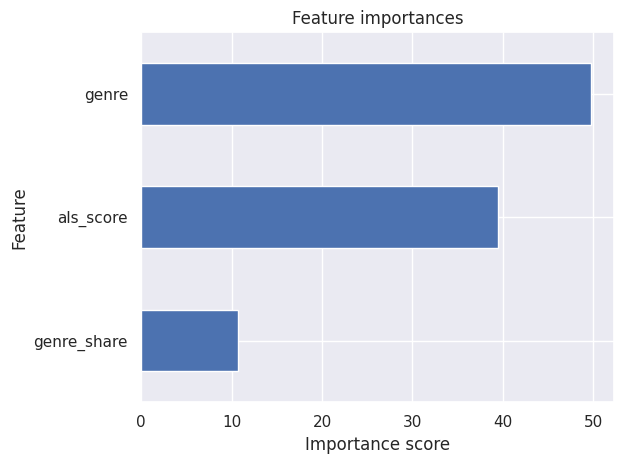

In [122]:
fi = pd.Series(
    model.feature_importances_,
    index=features,
    name="fi_personal_recs",
).sort_values()

fi.plot(kind="barh")
plt.title("Feature importances")
plt.ylabel("Feature")
plt.xlabel("Importance score")
plt.tight_layout()
plt.show()

# Окончательные рекомендации

Для расчета окончательных рекомендаций мы добавим к данным новую функцию: количество прослушиваний.

Сначала мы рассчитаем количество прослушиваний треков для каждого трека.:

In [123]:
popular = events_train.track_id \
            .value_counts() \
            .reset_index() \
            .merge(
                items[["track_id", "track", "artist"]],
                on="track_id",
                how="left",
            )[["track_id", "track", "artist", "count"]]
popular

,track_id,track,artist,count
0,53404,Smells Like Teen Spirit,Nirvana,24274
1,33311009,Believer,Imagine Dragons,22382
2,178529,Numb,Linkin Park,22198
3,35505245,I Got Love,Miyagi & Эндшпиль,21120
4,24692821,Way Down We Go,KALEO,18719
...,...,...,...,...
919736,436749,Taste The Red Hands,Dead Poetic,1
919737,61690343,Mémoire,Maes,1
919738,83778917,Я тебя закопаю под снег,prvrln,1
919739,88718967,IMMORTAL,JUNIOR FERRARI,1


In [124]:
candidates_for_train = candidates_for_train.merge(
    popular[["track_id", "count"]],
    on="track_id",
    how="left",
)
candidates_for_train.head()

,user_id,track_id,als_score,target,genre,genre_share,count
0,464,66322065,5.039634e-20,1,pop,0.245902,11314
1,503,43942453,6.802856e-20,1,local-indie,0.018300,15098
2,645,60292250,5.851431e-20,1,rnb,0.008675,16624
3,1209,60292250,5.641042e-21,1,rnb,0.008675,16624
4,2538,10776533,1.375346e-19,1,rock,0.047187,8683


In [125]:
candidates_to_rank_final = candidates_to_rank_final.merge(
    popular[["track_id", "count"]],
    on="track_id",
    how="left",
)
candidates_to_rank_final.head()

,user_id,track_id,als_score,genre,genre_share,count
0,4,53404,2.470839e-12,alternative,0.045580,24274.0
1,4,23559960,4.552044e-20,indie,0.024834,15384.0
2,4,1710811,3.458561e-20,rock,0.047187,12729.0
3,4,81848875,3.347138e-20,pop,0.245902,11436.0
4,4,60292250,3.272448e-20,rnb,0.008675,16624.0


In [126]:
candidates_to_rank_final.isna().sum()

user_id           0
track_id          0
als_score         0
genre             0
genre_share       0
count          2622
dtype: int64

In [127]:
features.append("count")
target = ["target"]

train_data = Pool(
    data=candidates_for_train[features],
    label=candidates_for_train[target],
    cat_features=cat_features,
)

model = CatBoostClassifier(**catboost_params)

model.fit(train_data)

0:	learn: 0.6798919	total: 3.27ms	remaining: 5.56s
100:	learn: 0.5927914	total: 298ms	remaining: 4.71s
200:	learn: 0.5733386	total: 566ms	remaining: 4.22s
300:	learn: 0.5621892	total: 829ms	remaining: 3.85s
400:	learn: 0.5534316	total: 1.11s	remaining: 3.6s
500:	learn: 0.5467932	total: 1.39s	remaining: 3.33s
600:	learn: 0.5421107	total: 1.69s	remaining: 3.09s
700:	learn: 0.5367795	total: 1.97s	remaining: 2.8s
800:	learn: 0.5322435	total: 2.29s	remaining: 2.57s
900:	learn: 0.5284104	total: 2.6s	remaining: 2.31s
1000:	learn: 0.5237072	total: 2.88s	remaining: 2.01s
1100:	learn: 0.5204380	total: 3.31s	remaining: 1.8s
1200:	learn: 0.5176297	total: 3.75s	remaining: 1.56s
1300:	learn: 0.5147901	total: 4.04s	remaining: 1.24s
1400:	learn: 0.5118787	total: 4.41s	remaining: 941ms
1500:	learn: 0.5092981	total: 4.71s	remaining: 624ms
1600:	learn: 0.5069761	total: 5s	remaining: 309ms
1699:	learn: 0.5041308	total: 5.21s	remaining: 0us


In [128]:
inf_data = Pool(data=candidates_to_rank_final[features], cat_features=cat_features)
predictions = model.predict_proba(inf_data)

candidates_to_rank_final["cb_score"] = predictions[:, 1]

candidates_to_rank_final = candidates_to_rank_final.sort_values(
    by=["user_id", "cb_score"], ascending=[True, False]
)
candidates_to_rank_final["rank"] = candidates_to_rank_final.groupby("user_id").cumcount() + 1

In [129]:
candidates_to_rank_final.head()

,user_id,track_id,als_score,genre,genre_share,count,cb_score,rank
3,4,81848875,3.347138e-20,pop,0.245902,11436.0,0.832675,1
4,4,60292250,3.272448e-20,rnb,0.008675,16624.0,0.818144,2
9,4,70619465,2.749917e-20,pop,0.245902,10130.0,0.726640,3
7,4,78194999,2.905115e-20,rusrap,0.112467,7192.0,0.671969,4
8,4,67538121,2.766610e-20,rusrap,0.112467,6769.0,0.493854,5


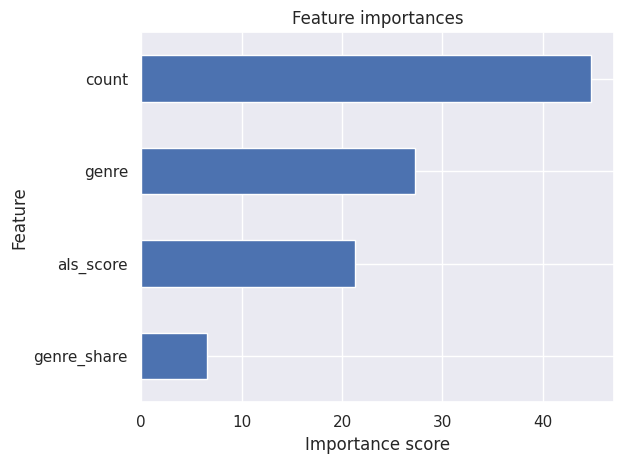

In [130]:
fi = pd.Series(
    model.feature_importances_,
    index=features,
    name="fi_final_recs",
).sort_values()

fi.plot(kind="barh")
plt.title("Feature importances")
plt.ylabel("Feature")
plt.xlabel("Importance score")
plt.tight_layout()
plt.show()

Полученные рекомендации представляют собой окончательные рекомендации, которые были ранжированы.

In [131]:
final_recommendations = candidates_to_rank_final.copy()

del candidates_to_rank_final
gc.collect()

3546

In [132]:
final_recommendations.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 1339780 entries, 3 to 1339773
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   user_id      1339780 non-null  int32  
 1   track_id     1339780 non-null  int32  
 2   als_score    1339780 non-null  float64
 3   genre        1339780 non-null  object 
 4   genre_share  1339780 non-null  float64
 5   count        1337158 non-null  float64
 6   cb_score     1339780 non-null  float64
 7   rank         1339780 non-null  int64  
dtypes: float64(4), int32(2), int64(1), object(1)
memory usage: 151.4 MB


In [133]:
try:
    final_recommendations.to_parquet("data/recommendations.parquet")
except OSError:
    final_recommendations.to_parquet("recommendations.parquet")

# Очистка памяти, чтобы не падало ядро

In [134]:
import joblib
import gc

print("Сохранение данных...")

# 1. Сохраняем items если еще не сохранены
if 'items' in locals():
    try:
        items.to_parquet("items_final.parquet", index=False)
        print("✓ items сохранены")
    except:
        pass

# 2. Сохраняем events если еще не сохранены
if 'events' in locals():
    try:
        events.to_parquet("events_final.parquet", index=False)
        print("✓ events сохранены")
    except:
        pass

# 3. Сохраняем candidates_to_rank_personal
if 'candidates_to_rank_personal' in locals():
    try:
        candidates_to_rank_personal.to_parquet("candidates_to_rank_personal_final.parquet", index=False)
        print("✓ candidates_to_rank_personal сохранены")
    except:
        pass

# 4. Сохраняем final_recommendations
if 'final_recommendations' in locals():
    try:
        final_recommendations.to_parquet("final_recommendations_final.parquet", index=False)
        print("✓ final_recommendations сохранены")
    except:
        pass

# 5. Сохраняем events_train
if 'events_train' in locals():
    try:
        events_train.to_parquet("events_train_final.parquet", index=False)
        print("✓ events_train сохранены")
    except:
        pass

# 6. Сохраняем events_test_2
if 'events_test_2' in locals():
    try:
        events_test_2.to_parquet("events_test_2_final.parquet", index=False)
        print("✓ events_test_2 сохранены")
    except:
        pass

# 7. Сохраняем inference_data
if 'inference_data' in locals():
    try:
        inference_data.to_parquet("inference_data_final.parquet", index=False)
        print("✓ inference_data сохранены")
    except:
        pass

# 8. Сохраняем cold_users как список
if 'cold_users' in locals():
    try:
        with open("cold_users.pkl", "wb") as f:
            joblib.dump(list(cold_users), f)
        print("✓ cold_users сохранены")
    except:
        pass

# 9. Сохраняем top_popular
if 'top_popular' in locals():
    try:
        top_popular.to_parquet("top_popular_final.parquet", index=False)
        print("✓ top_popular сохранены")
    except:
        pass

print("Все данные сохранены. Очистка памяти...")

# Очищаем всю память
gc.collect()

# Удаляем все большие объекты
to_delete = [
    'tracks', 'catalog_names', 'events_sample', 'genres', 
    'track_names', 'albums', 'artists', 'items_track_ids',
    'events_track_ids', 'no_listens_ids', 'events_user_ids',
    'events_user_ids_new', 'id2month_mapping', 'item_encoder',
    'user_encoder', 'track_popularity', 'events_train', 
    'events_test', 'events_labels', 'candidates', 'candidates_for_train',
    'genre_shares', 'als_model', 'als_recommendations', 'similar_items',
    'als_model_inference', 'als_recommendations_inference', 'user_item_matrix_train',
    'user_item_matrix_inference', 'train_data', 'model', 'inf_data',
    'predictions', 'popular', 'candidates_to_rank', 'candidates_to_rank_final',
    'final_recommendations', 'inference_data', 'events_cold', 'events_cold_top',
    'top_listened_share', 'events_recs_for_binary_metric', 'precision_at_5_personal',
    'recall_at_5_personal', 'coverage_personal'
]

for var in to_delete:
    if var in locals():
        del locals()[var]
    elif var in globals():
        del globals()[var]

# Принудительный сбор мусора
gc.collect()
print("Память очищена. Перезапускаем ядро для чистого состояния...")

Сохранение данных...
✓ items сохранены
✓ events сохранены
✓ candidates_to_rank_personal сохранены
✓ final_recommendations сохранены
✓ events_train сохранены
✓ events_test_2 сохранены
✓ inference_data сохранены
✓ cold_users сохранены
✓ top_popular сохранены
Все данные сохранены. Очистка памяти...
Память очищена. Перезапускаем ядро для чистого состояния...


# Загружаем нужные данные

In [3]:
# Загружаем сохраненные данные
print("Загрузка сохраненных данных...")

try:
    items = pd.read_parquet("items_final.parquet")
    print("✓ items загружены")
except:
    try:
        items = pd.read_parquet("data/items.parquet")
        print("✓ items загружены из data/")
    except:
        items = pd.read_parquet("items.parquet")
        print("✓ items загружены")

try:
    events = pd.read_parquet("events_final.parquet")
    print("✓ events загружены")
except:
    try:
        events = pd.read_parquet("data/events.parquet")
        print("✓ events загружены из data/")
    except:
        events = pd.read_parquet("events.parquet")
        print("✓ events загружены")

try:
    candidates_to_rank_personal = pd.read_parquet("candidates_to_rank_personal_final.parquet")
    print("✓ candidates_to_rank_personal загружены")
except:
    print("✗ candidates_to_rank_personal не найдены")

try:
    final_recommendations = pd.read_parquet("final_recommendations_final.parquet")
    print("✓ final_recommendations загружены")
except:
    print("✗ final_recommendations не найдены")

try:
    events_train = pd.read_parquet("events_train_final.parquet")
    print("✓ events_train загружены")
except:
    print("✗ events_train не найдены")

try:
    events_test_2 = pd.read_parquet("events_test_2_final.parquet")
    print("✓ events_test_2 загружены")
except:
    print("✗ events_test_2 не найдены")

try:
    inference_data = pd.read_parquet("inference_data_final.parquet")
    print("✓ inference_data загружены")
except:
    print("✗ inference_data не найдены")

try:
    cold_users = set(joblib.load("cold_users.pkl"))
    print("✓ cold_users загружены")
except:
    print("✗ cold_users не найдены")

try:
    top_popular = pd.read_parquet("top_popular_final.parquet")
    print("✓ top_popular загружены")
except:
    try:
        top_popular = pd.read_parquet("data/top_popular.parquet")
        print("✓ top_popular загружены из data/")
    except:
        top_popular = pd.read_parquet("top_popular.parquet")
        print("✓ top_popular загружены")

print("Все данные загружены!")

Загрузка сохраненных данных...
✓ items загружены
✓ events загружены
✓ candidates_to_rank_personal загружены
✓ final_recommendations загружены
✓ events_train загружены
✓ events_test_2 загружены
✓ inference_data загружены
✓ cold_users загружены
✓ top_popular загружены
Все данные загружены!


# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

# Базовые рекомендации: популярные треки

Для этого подхода не требуется обучение модели. Мы просто посчитаем общее количество взаимодействий с каждым треком. Результат покажет, сколько рекомендаций из топа популярных треков было фактически прослушано пользователями.

In [4]:
events_cold = events[events.user_id.isin(cold_users)].drop("tracks_played", axis=1)
events_cold.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244387 entries, 19859 to 10794098
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           244387 non-null  int32         
 1   track_id          244387 non-null  int32         
 2   started_at        244387 non-null  datetime64[ns]
 3   user_id_encoded   244387 non-null  int64         
 4   track_id_encoded  244387 non-null  int64         
dtypes: datetime64[ns](1), int32(2), int64(2)
memory usage: 9.3 MB


In [5]:
events_cold.head()

,user_id,track_id,started_at,user_id_encoded,track_id_encoded
19859,353,3735369,2022-04-04,81,152210
19860,353,5310285,2022-05-23,81,182512
19861,353,9439965,2022-05-23,81,212793
19862,353,17198143,2022-06-06,81,272412
19863,353,17326708,2022-06-25,81,275073


In [6]:
events_cold_top = events_cold.merge(
    top_popular[["track_id", "tracks_played"]],
    on="track_id",
    how="left",
)
events_cold_top.head()

,user_id,track_id,started_at,user_id_encoded,track_id_encoded,tracks_played
0,353,3735369,2022-04-04,81,152210,NaN
1,353,5310285,2022-05-23,81,182512,NaN
2,353,9439965,2022-05-23,81,212793,NaN
3,353,17198143,2022-06-06,81,272412,NaN
4,353,17326708,2022-06-25,81,275073,NaN


In [7]:
events_cold_top.isna().sum()

user_id                  0
track_id                 0
started_at               0
user_id_encoded          0
track_id_encoded         0
tracks_played       237256
dtype: int64

In [8]:
top_listened_share = events_cold_top \
                            .groupby("user_id")["tracks_played"] \
                            .apply(lambda x: x.notnull().mean())
top_listened_share

user_id
353       0.000000
786       0.016173
794       0.000000
883       0.033333
1115      0.043478
            ...   
302292    0.171875
302463    0.032258
302661    0.045455
302930    0.061069
303562    0.000000
Name: tracks_played, Length: 1487, dtype: float64

In [9]:
recall_gen = top_listened_share.mean()
print(f"Recall for top popular: {recall_gen:.5f}")

Recall for top popular: 0.05192


# ALS
Recall / Precision

In [10]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):
    """Labels <user_id, track_id> pairs for common users with features:
    - gt => ground truth
    - pr => prediction
    top_k => using top-k recommendations for computation
    """
    
    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    events_for_common_users = events_for_common_users[events_for_common_users["track_id"].isin(
        events_train["track_id"].unique()
    )
    ]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "track_id", "gt"]].merge(
        recs_for_common_users[["user_id", "track_id", "score"]], 
        on=["user_id", "track_id"], 
        how="outer",
    )    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

In [11]:
events_recs_for_binary_metric = process_events_recs_for_binary_metrics(
    inference_data,
    events_test_2,
    candidates_to_rank_personal.rename(columns={"cb_score": "score"}),
    top_k=5,
)

Common users: 133978


In [12]:
def compute_cls_metrics(events_recs_for_binary_metric):
    """Computes precision and recall."""
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # Computing precision
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # Computing recall
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall

In [13]:
precision_at_5_personal, recall_at_5_personal = compute_cls_metrics(events_recs_for_binary_metric)

print(f"Precision@5 = {precision_at_5_personal:.5f} ({precision_at_5_personal:.3%})")
print(f"Recall@5 = {recall_at_5_personal:.5f} ({recall_at_5_personal:.3%})")

Precision@5 = 0.00288 (0.288%)
Recall@5 = 0.00197 (0.197%)


# Coverage

In [14]:
coverage_personal = candidates_to_rank_personal.track_id.nunique() / items.shape[0]
print(f"Coverage = {coverage_personal} ({coverage_personal:.3%})")

Coverage = 0.00095 (0.095%)


# Novelty

In [15]:
events_train["seen"] = True

candidates_to_rank_personal = candidates_to_rank_personal.merge(
    events_train, 
    on=["user_id", "track_id"], 
    how="left"
)

candidates_to_rank_personal["seen"] = candidates_to_rank_personal["seen"].fillna(False).astype("bool")

In [16]:
candidates_to_rank_personal = candidates_to_rank_personal.sort_values(by="als_score", ascending=False)
candidates_to_rank_personal["rank"] = candidates_to_rank_personal.groupby("user_id").cumcount() + 1

In [17]:
novelty_at_5_personal = (1 - candidates_to_rank_personal.query("rank <= 5").groupby("user_id")["seen"].mean())
novelty_at_5_personal = novelty_at_5_personal.mean()

print(f"Novelty@5 = {novelty_at_5_personal:.4f}")

Novelty@5 = 0.9580


# Финальные  рекомендации
Recall/Precision

In [18]:
events_recs_for_binary_metric = process_events_recs_for_binary_metrics(
    inference_data,
    events_test_2,
    final_recommendations.rename(columns={"cb_score": "score"}),
    top_k=5,
)

Common users: 133978


In [19]:
precision_at_5_final, recall_at_5_final = compute_cls_metrics(events_recs_for_binary_metric)

print(f"Precision@5 = {precision_at_5_final:.5f} ({precision_at_5_final:.3%})")
print(f"Recall@5 = {recall_at_5_final:.5f} ({recall_at_5_final:.3%})")

Precision@5 = 0.00338 (0.338%)
Recall@5 = 0.00241 (0.241%)


# Coverage

In [20]:
coverage_final = final_recommendations.track_id.nunique() / items.shape[0]
print(f"Coverage = {coverage_final} ({coverage_final:.3%})")

Coverage = 0.00095 (0.095%)


# Novelty

In [21]:
events_train["seen"] = True

final_recommendations = final_recommendations.merge(
    events_train, 
    on=["user_id", "track_id"], 
    how="left"
)

final_recommendations["seen"] = final_recommendations["seen"].fillna(False).astype("bool")

In [22]:
final_recommendations = final_recommendations.sort_values(by="als_score", ascending=False)
final_recommendations["rank"] = final_recommendations.groupby("user_id").cumcount() + 1

In [23]:
novelty_at_5_final = (1 - final_recommendations.query("rank <= 5").groupby("user_id")["seen"].mean())
novelty_at_5_final = novelty_at_5_final.mean()

print(f"Novelty@5 = {novelty_at_5_personal:.4f}")

Novelty@5 = 0.9580


# === Выводы, метрики ===

In [24]:
top_popular_metrics = pd.Series([recall_gen], index=["recall_gen"], name="top_popular")

personal_als_metrics = pd.Series(
    [
        precision_at_5_personal, 
        recall_at_5_personal, 
        coverage_personal, 
        novelty_at_5_personal
    ], 
    index=["precision_at_5", "recall_at_5", "coverage", "novelty_at_5"],
    name="personal_als"
)

final_recs_metrics = pd.Series(
    [
        precision_at_5_final, 
        recall_at_5_final, 
        coverage_final, 
        novelty_at_5_final
    ], 
    index=["precision_at_5", "recall_at_5", "coverage", "novelty_at_5"],
    name="final_recs",
)

pd.concat([top_popular_metrics, personal_als_metrics, final_recs_metrics], axis=1)

,top_popular,personal_als,final_recs
recall_gen,0.051925,NaN,NaN
precision_at_5,NaN,0.002875,0.003375
recall_at_5,NaN,0.001967,0.002412
coverage,NaN,0.000950,0.000950
novelty_at_5,NaN,0.958026,0.958026


# Анализ результатов

1. Новые признаки: Добавление данных о прослушивании улучшило точность и полноту рекомендаций.

2. Популярные треки: Простой подход (топ-N популярных) показал высокую эффективность, возможно, из-за использования лишь 25% данных, что могло ухудшить результаты ALS.

3. Новизна: Методы вроде ALS хорошо рекомендуют новые треки, но высокую новизну может давать и случайный подбор.

4. Охват каталога: Низкий охват — рекомендации покрывают малую часть каталога — ожидаем при выдаче всего 10 позиций и сфокусированных интересах пользователей.